# SAS Pain Points
# And their Remedies with Python

Data Analysis in SAS is clunky. Here are three pain points:

1. It’s not straightforward to compare different models
2. SAS syntax is not conducive to quick exploratory data analysis
3. SAS lacks modern tools for doing an analysis and sharing it

Python with Pandas solves these problems, and is a delight to use.

# Pain Point 1
# In SAS, it’s not straightforward to run and compare many models
Use case: You want to run a few different regression models, then extract some model estimates, and create a summary table.

## SAS
Source: http://www.lexjansen.com/nesug/nesug12/sa/sa15.pdf

We will add one variable at a time from `vars` into a linear regression model containing all `base_vars`.

Pain point:
* extracting parameter estimates requires inspecting ODS trace output - which requires switching to the log

<img align="left" src="img/reg1.png" >

Next, we'll create and run the regression macro.

Pain points:
* Macro syntax is powerful but clunky
* Using `%scan` and `%eval` is very verbose
* Again, need to know the ODS table names to extract output

<img align="left" src="img/reg2.png" >

Finally, we combine the output.

Pain points:
* Using length statements...
* Simple printing is very verbose

<img align="left" src="img/reg3.png" >

## With Python

Using a modern tool like Python is much easier.

In [1]:
# include some common code modules
import statsmodels.api as sm
import numpy as np
import pandas as pd

In [2]:
# in one line, we download a dataset and create a data frame
df = sm.datasets.get_rdataset("Guerry", "HistData").data

In [3]:
# Succint printing 
df.head()

,dept,Region,Department,Crime_pers,Crime_prop,Literacy,Donations,Infants,Suicides,MainCity,...,Crime_parents,Infanticide,Donation_clergy,Lottery,Desertion,Instruction,Prostitutes,Distance,Area,Pop1831
0,1,E,Ain,28870,15890,37,5098,33120,35039,2:Med,...,71,60,69,41,55,46,13,218.372,5762,346.03
1,2,N,Aisne,26226,5521,51,8901,14572,12831,2:Med,...,4,82,36,38,82,24,327,65.945,7369,513.00
2,3,C,Allier,26747,7925,13,10973,17044,114121,2:Med,...,46,42,76,66,16,85,34,161.927,7340,298.26
3,4,E,Basses-Alpes,12935,7289,46,2733,23018,14238,1:Sm,...,70,12,37,80,32,29,2,351.399,6925,155.90
4,5,E,Hautes-Alpes,17488,8174,69,6962,23076,16171,1:Sm,...,22,23,64,79,35,7,1,320.280,5549,129.10


In [4]:
# clean way to specify base variables
base_vars = ['Distance', 'Literacy', 'Wealth']

### Running one regression model
Requires 4 lines of code - including the data manipulation.

In [5]:
X = df[base_vars]
y = df['Lottery']

In [6]:
regression = sm.OLS(y, X).fit()

In [7]:
regression.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Lottery   R-squared:                       0.791
Model:                            OLS   Adj. R-squared:                  0.783
Method:                 Least Squares   F-statistic:                     104.7
Date:                Fri, 11 Nov 2016   Prob (F-statistic):           3.96e-28
Time:                        13:21:24   Log-Likelihood:                -391.29
No. Observations:                  86   AIC:                             788.6
Df Residuals:                      83   BIC:                             795.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Distance       0.0584      0.022      2.595      0.011         0.014     0.103
Literacy       0.1115      0.093      1.196      0.235        -0.074     0.297
Wealth         0.5664      0.102      5.551      0.000         0.363     0.769
==============================================================================
Omnibus:                        6.220   Durbin-Watson:                   1.747
Prob(Omnibus):                  0.045   Jarque-Bera (JB):                6.414
Skew:                          -0.651   Prob(JB):                       0.0405
Kurtosis:                       2.691   Cond. No.                         10.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Running bulk regression in Python
Below, we will construct our own regression summary table, instead of using the above `summary` table.

In [8]:
# (base vars as above)
base_vars = ['Distance', 'Literacy', 'Wealth']

In [9]:
# add one of these at a time, to model containing `base_vars`
vars = ['Crime_pers', 'Crime_prop', 'Commerce', 'Area', 'Pop1831', 'Instruction']

In [10]:
# much of this code is self-documenting: it's clear what is going on

# for storing combined data 
combined_data = []

for i in range(len(vars)):
    
    predictors = base_vars + [vars[i]]
    
    X = df[predictors]
    y = df['Lottery']

    # one line of code to fit an OLS regression model
    regression = sm.OLS(y, X).fit()

    # use a pandas (pd) function to create a data frame
    summary = pd.DataFrame(
        {
            'Model': i+1,  # yes, python has 0-base indexing
            'coefficient': regression.params,
            'error' :regression.bse,
            't': regression.tvalues,
            'p-value': regression.pvalues
        },
        # pandas uses an index column
        index=regression.params.index)

    # append each result `summary` table (we'll have 6 of these)
    combined_data.append(summary)

In [11]:
# convert output data to a pandas data frame
combined_df = pd.concat(combined_data)

In [12]:
combined_df.head(10)

,Model,coefficient,error,p-value,t
Distance,1,0.060921,0.021029,0.004830,2.896940
Literacy,1,-0.141700,0.111717,0.208249,-1.268388
Wealth,1,0.428025,0.102673,0.000075,4.168800
Crime_pers,1,0.000864,0.000239,0.000506,3.621784
Distance,2,0.029791,0.022055,0.180477,1.350794
Literacy,2,-0.019217,0.092519,0.835974,-0.207705
Wealth,2,0.338218,0.111020,0.003114,3.046464
Crime_prop,2,0.002846,0.000731,0.000200,3.893559
Distance,3,0.025131,0.023321,0.284360,1.077627
Literacy,3,0.133158,0.088046,0.134284,1.512372


## Bulk Regression: Summary

### SAS pain points
* In SAS you need to inspect ODS trace output in order to select the correct parameter table names (you’d have to switch to the log to do this).
* Granted, SAS macro language is powerful - but using `%eval` and `%scan` is very verbose
* Extracting the parameters from the ODS table is very clunky.

### Python remedies
* Extracting parameters, p-values, etc is easy with TAB auto-completion.
* Data manipulation can happen anywhere (no need for `data` step nor `proc` steps).
* You can just write a for loop if you want (SAS would require `proc iml`)

## Extra: Extending this with Python Scikit-Learn Pipelines

In SAS, combining *different* algorithms would require lots of code, which would have to be heavily restructured for each new algorithm.

On the other hand, Python pipelines are very concise. Below is all the code needed to create some sample data, scale it, do dimension reduction with PCA, and finaly implement a linear model.

In [13]:
# load some scikit-learn modules
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression

from sklearn.pipeline import Pipeline
import numpy as np

In [14]:
# create random normal data matrices
X = np.random.randn(20, 40)
y = np.random.randn(20)

In [15]:
# pipeline: a lightweight tool for heavy-duty tasks
# here, the pipeline scales the input data, then runs PCA, and then runs Linear Regression
# all in less than 10 lines of code
# Q: How many lines of code would need to be written in SAS to perform these steps?
pipeline = Pipeline(
    [
        ('scaling', StandardScaler()),
        ('pca', PCA(n_components=5)),
        ('lm', LinearRegression())
    ]
)

# run the pipeline 
pipe = pipeline.fit(X, y)

In [16]:
# the last step was an estimator, so let's focus on that
lm_out = pipe.named_steps['lm']

In [17]:
# use TAB auto-completion after the .
lm_out.coef_

array([ 0.08284551,  0.13567036,  0.02069962,  0.10256009,  0.02469913])

# Pain Point 2
# SAS is not conducive to exploratory data analysis

Use case: In data analysis, you need to know your data well. You want the software to help you easily explore your data. SAS syntax is verbose, and you also have a weird dichotomy of proc’s and data steps.

Let's demonstrates this with an example use case. Specifically, we want to:
* load some external data
* create a few graphics
* do some data manipulation
* export data to CSV

## SAS

Pain points:
* Viewing the plots requires switching to HTML output
* Merging requires sorting (!)
* Useful functionality is missing or hard to implement (e.g., rows/columns of dataset)
* SAS implements dichotomy of proc vs data step: you can't just "do" something
* Syntax is verbose (printing, reading in CSVs, `run;`)

<img align="left" src="img/pain2.png" >

## Exploratory data analysis with Python

Syntax is clean, graphics are in-line, and you can just do a for loop if you like.

In [18]:
%matplotlib inline
import pandas as pd
import seaborn as sns

/Users/pawel/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [19]:
tips = pd.read_csv('data/tips.csv')

In [20]:
tips.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


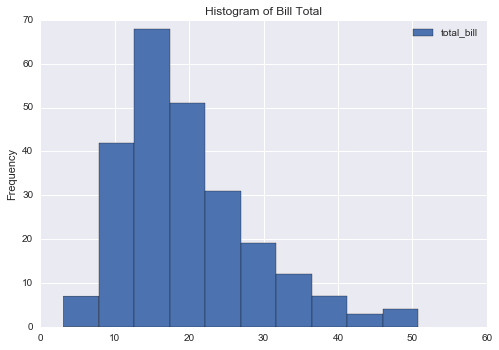

In [21]:
tips.plot(y="total_bill", kind="hist", title="Histogram of Bill Total");

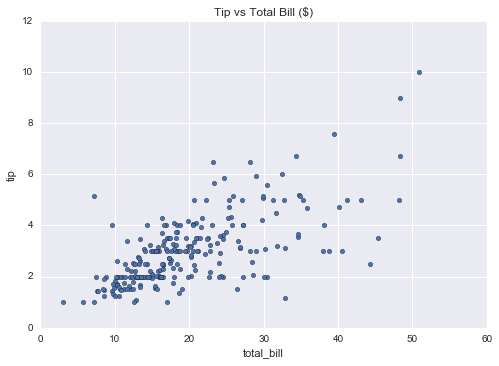

In [22]:
tips.plot(x="total_bill", y="tip", kind="scatter", title="Tip vs Total Bill ($)");

In [23]:
tips = tips.assign(idvar=range(tips.shape[0]))

In [24]:
tips.head()

,total_bill,tip,sex,smoker,day,time,size,idvar
0,16.99,1.01,Female,No,Sun,Dinner,2,0
1,10.34,1.66,Male,No,Sun,Dinner,3,1
2,21.01,3.50,Male,No,Sun,Dinner,3,2
3,23.68,3.31,Male,No,Sun,Dinner,2,3
4,24.59,3.61,Female,No,Sun,Dinner,4,4


In [25]:
small_groups = tips.query("size < 4")

small_groups = small_groups.assign(small_group = True)

In [26]:
# merge
merged = pd.merge(tips,
                  small_groups[['idvar', 'small_group']],
                  on='idvar',
                  how='left'
                 )

In [27]:
merged.head()

,total_bill,tip,sex,smoker,day,time,size,idvar,small_group
0,16.99,1.01,Female,No,Sun,Dinner,2,0,True
1,10.34,1.66,Male,No,Sun,Dinner,3,1,True
2,21.01,3.50,Male,No,Sun,Dinner,3,2,True
3,23.68,3.31,Male,No,Sun,Dinner,2,3,True
4,24.59,3.61,Female,No,Sun,Dinner,4,4,NaN


In [28]:
# how to do this in SAS?
merged.shape

(244, 9)

In [29]:
tips.shape

(244, 8)

In [30]:
# save as CSV
tips.to_csv('tips2.csv')

### Side-by-side code comparison

<img align="left" src="img/compared.png" >

Other examples of syntax sylliness in SAS that doesn't appear in a modern language like Python:

* `length my_var $3. ;`: who needs this in 2016?
* keep vs retain: sound the same, do very different things
* `cards;` (as in, punchcards...) still exists
* SAS has clunky title statements (required if you want to find your code in the LST file!)
* SAS requires semicolons, `quit;` and `run;`

# Pain Point 3
# SAS lacks modern tools for data analysis (and for sharing results)

The list is extensive:

* SAS has no clean interface for quick data exploration
* SAS doesn't have a real interactive mode (like a console). Even in basic SAS GUI, all output is in a separate window from the code
* There are antique log/listing files that require clunky title separations to find your result
* SAS GUI design leaves a lot to be desired
* There is no Mac version
* SAS is not free

On the other hand, Jupyter is a great tool for data analysis with Python and a great way to share results (including as a presentation).

This file is a Jupyter notebook, which is easy to use, has useful features, and is free and cross-platform.

The Python ecosystem solves all of the above pain points.

## One More Thing: Finding Help

With any tool, you will need help. An easy way to find help is extremely beneficial, and this is another area where Python simply comes out on top.

SAS has a bunch of PDF papers (which, granted, sometimes have clever titles), but it’s difficult to copy-paste code from PDFs. These documents are very verbose, in contrast of the quick and easy Stack Overflow posts. While SAS does have professional support, Python is much more transparent: much of the code is open source, so even if you can't find the help you need (unlikely), you can just inspect the code yourself.

Also, a small annoyance: SAS forum help doesn’t usually have fixed-width fonts, which is very frustrating to look at (as opposed to easy markdown formatting supported on Stack Overflow and other websites).

Here is an example SAS paper (from Lex Jansen):

![lex](img/lex_jansen1.png)

---
... And even worse are SAS forums

## In Contrast: Modern Online Help

Stack Overflow is the current standard for finding help. And if you need example code, Github can't be beat. The Python community is extremely active on both, in stark contrast to SAS, as shown next.

In [ ]:
import numpy as np

stack_tags = pd.DataFrame(np.array([[639996, 155174, 6965], [689219, 84634, 402]]),
                          columns=["Python", "R", "SAS"],
                          index=["Stack Overflow", "Github"]
                         )

In [ ]:
stack_tags.plot.bar(title="Online Help Available");

# Summary
# Resolving SAS Pain Points with Python
Data Analysis in SAS is clunky. Here are three pain points solved with Python and its ecosystem:

1. Running and comparing many models is easy. Plus, chaining different algorithms with Python's pipelines is powerful but concise.
2. Python syntax is conducive to quick data exploration.
3. The Python ecosystem, including Jupyter notebook, makes it easy to share analyses and find useful help.


# References

Documentation for the egression example data (Guerry) http://vincentarelbundock.github.io/Rdatasets/doc/HistData/Guerry.html

Bulk Regression in SAS (PDF) http://www.lexjansen.com/nesug/nesug12/sa/sa15.pdf

Images of code use the [Solarized theme (light)](http://ethanschoonover.com/solarized) inside Emacs.


http://www.lexjansen.com/pnwsug/2007/Paul%20Hamilton%20-%2010%20Things%20I%20Hate%20in%20SAS%20coding.pdf
